In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
import glob

In [4]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_vgg16_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained VGG16 Model """
    vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=inputs)
    vgg16.trainable = False ## Not trainable weights

    """ Encoder """
    s1 = vgg16.get_layer("block1_pool").output         ## (112 x 112)
    s2 = vgg16.get_layer("block2_pool").output         ## (56 x 56)
    s3 = vgg16.get_layer("block3_pool").output         ## (28 x 28)
    s4 = vgg16.get_layer("block4_pool").output         ## (14 x 14)

    """ Bridge """

    b1 = vgg16.get_layer("block5_pool").output         ## (7 x 7)
    

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (14 x 14)
    d2 = decoder_block(d1, s3, 256)                     ## (28 x 28)
    d3 = decoder_block(d2, s2, 128)                     ## (56 x 56)
    d4 = decoder_block(d3, s1, 64)                      ## (112 x 112)

    """ Output """
    
    d5 = Conv2DTranspose(64, (2, 2), strides=2, padding="same")(d4)
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d5)

    model = Model(inputs, outputs, name="VGG16_U-Net")
    return model

if __name__ == "__main__":
    input_shape = (224, 224, 3)
    model = build_vgg16_unet(input_shape)
    model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "VGG16_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                       

In [5]:
from os import listdir
from numpy import asarray
from numpy import save
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
# define location of dataset
folder1 = '/content/gdrive/MyDrive/Leaf_DataSet/Data/Images/'
folder2 ='/content/gdrive/MyDrive/Leaf_DataSet/Data/Masks/'
photos, labels = list(), list()


In [6]:
# enumerate files in the directory
for file in listdir(folder1):
   
	photo = load_img(folder1 + file, target_size=(224, 224))
	# convert to numpy array
	photo = img_to_array(photo)
	# store
	photos.append(photo)
photos = asarray(photos)    
for file in listdir(folder2):
   
  photo = load_img(folder2 + file, target_size=(224,224))
  photo = img_to_array(photo)
  b,g,r = cv2.split(photo)
  rgb_img = cv2.merge([r,g,b])
  photo = cv2.cvtColor(photo,cv2.COLOR_BGR2GRAY)
  photo = img_to_array(photo)  
  labels.append(photo)
# convert to a numpy arrays
labels=asarray(labels)
print(photos.shape, labels.shape)




(624, 224, 224, 3) (624, 224, 224, 1)


In [7]:
#Normalize images
photos = photos /255.  #Can also normalize or scale using MinMax scaler
#Do not normalize masks, just rescale to 0 to 1.
labels = labels /255.  #PIxel values will be 0 or 1

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(photos,labels, test_size = 0.20, random_state = 42)


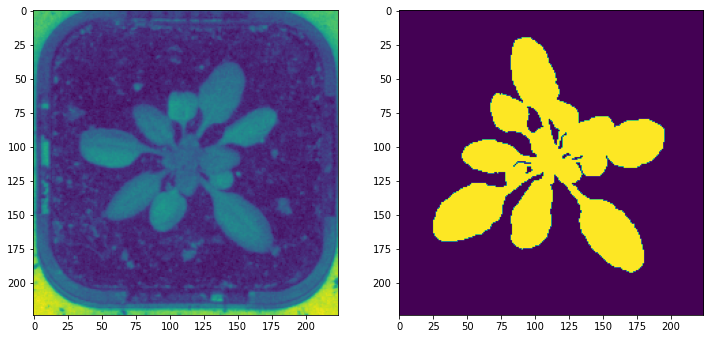

In [9]:
#Sanity check, view few mages
import random

image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,0])
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0])
plt.show()

In [10]:
IMG_HEIGHT = photos.shape[1]
IMG_WIDTH  = photos.shape[2]
IMG_CHANNELS = photos.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [11]:
model = build_vgg16_unet(input_shape)
model.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "VGG16_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                       

In [30]:
history = model.fit(X_train, y_train, 
                    batch_size = 20, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/100
25/25 [==============================] - 17s 689ms/step - loss: 0.0183 - accuracy: 0.9922 - val_loss: 0.8293 - val_accuracy: 0.8832
Epoch 2/100
25/25 [==============================] - 17s 686ms/step - loss: 0.0175 - accuracy: 0.9924 - val_loss: 0.8534 - val_accuracy: 0.8827
Epoch 3/100
25/25 [==============================] - 17s 685ms/step - loss: 0.0176 - accuracy: 0.9923 - val_loss: 0.8431 - val_accuracy: 0.8815
Epoch 4/100
25/25 [==============================] - 17s 684ms/step - loss: 0.0186 - accuracy: 0.9918 - val_loss: 0.8409 - val_accuracy: 0.8820
Epoch 5/100
25/25 [==============================] - 17s 685ms/step - loss: 0.0204 - accuracy: 0.9911 - val_loss: 0.8290 - val_accuracy: 0.8827
Epoch 6/100
25/25 [==============================] - 17s 685ms/step - loss: 0.0211 - accuracy: 0.9907 - val_loss: 0.8650 - val_accuracy: 0.8845
Epoch 7/100
25/25 [==============================] - 17s 685ms/step - loss: 0.0213 - accuracy: 0.9906 - val_loss: 0.8573 - val_accuracy:

(1, 224, 224, 3)
(224, 224)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


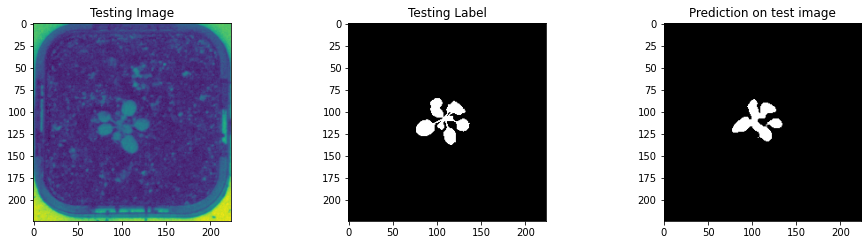

number of white pixels in ground truth label  1342
number of black pixels in ground truth label  48834
total number of pixels in ground truth label 50176
Ground_truth Leaf Area Index value of a plant is  0.027480853503706434
 
number of white pixels in predicted label 1144
number of black pixels in predicted label 49032
total number of pixels in predicted label 50176
Predicted Leaf Area Index of plant is  0.023331701745798662


In [57]:
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)
print(prediction)
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

#calculating Leaf Area Index



number_of_white_pix_t = np.sum(ground_truth == 1)
number_of_black_pix_t = np.sum(ground_truth == 0)
total_t= number_of_white_pix_t + number_of_black_pix_t
Leaf_Area_index_t= number_of_white_pix_t/number_of_black_pix_t
print('number of white pixels in ground truth label ',number_of_white_pix_t)
print('number of black pixels in ground truth label ',number_of_black_pix_t)
print('total number of pixels in ground truth label',total_t)
print("Ground_truth Leaf Area Index value of a plant is ",Leaf_Area_index_t)
print(" ")

number_of_white_pix = np.sum(prediction == 1)
number_of_black_pix = np.sum(prediction == 0)
total= number_of_white_pix + number_of_black_pix

print('number of white pixels in predicted label',number_of_white_pix)
print('number of black pixels in predicted label',number_of_black_pix)
print('total number of pixels in predicted label',total)

Leaf_Area_index= number_of_white_pix/number_of_black_pix
print("Predicted Leaf Area Index of plant is ",Leaf_Area_index)

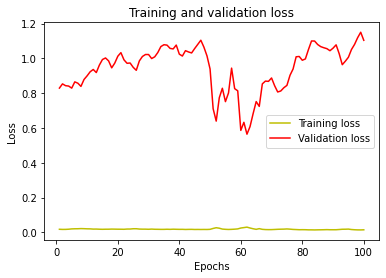

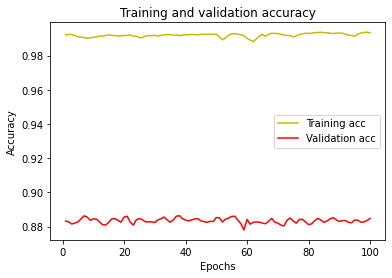

In [58]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [59]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5
                    

In [60]:
from tensorflow.keras.metrics import MeanIoU

In [61]:
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.67427295


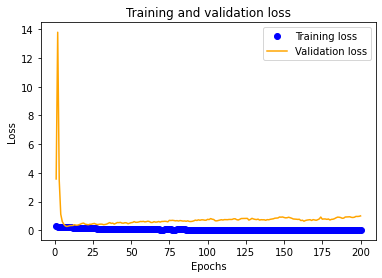

In [42]:
history_dict = history.history
# Learning curve(Loss)
# let's see the training and validation loss by epoch

# loss
loss_values = history_dict['loss'] # you can change this
val_loss_values = history_dict['val_loss'] # you can also change this

# range of X (no. of epochs)
epochs = range(1, len(loss_values) + 1) 

# plot
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

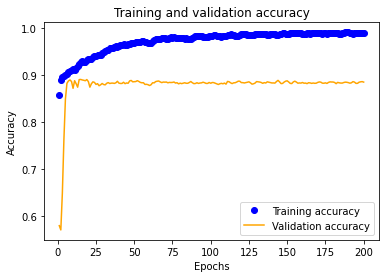

0.8901088833808899

In [20]:
# Learning curve(accuracy)
# let's see the training and validation accuracy by epoch

# accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

# plot
# "bo" is for "blue dot"
plt.plot(epochs, acc, 'bo', label='Training accuracy')
# orange is for "orange"
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# this is the max value - should correspond to
# the HIGHEST train accuracy
np.max(val_acc)
